In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
data = pd.read_csv('/Users/beckettdowhan/Downloads/data_cleaned.csv', low_memory=False)

In [7]:
len(data)

490906

In [11]:
# Separate swing from take data 

swing_data = data[data['Swing/Take'] == 'Swing']
take_data = data[data['Swing/Take'] == 'Take']

In [13]:
X_swing = swing_data[['Count', 'PlateLocHeight', 'PlateLocSide']]
y_swing = swing_data['target']
X_take = take_data[['Count', 'PlateLocHeight', 'PlateLocSide']]
y_take = take_data['target']

In [21]:
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# Define features
columns_to_scale = ['PlateLocHeight', 'PlateLocSide']
columns_to_leave = ['Count']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', columns_to_leave)
    ]
)

# XGBRegressor model
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=5,                  # Maximum depth of trees
    subsample=0.8,                # Subsample ratio of the training data
    colsample_bytree=0.8,         # Subsample ratio of features for each tree
    random_state=42               # Random seed
)

# Pipeline
pipeline_swing = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('model', xgb_model)             # XGBoost model
])

X_train, X_test, y_train, y_test = train_test_split(X_swing, y_swing, test_size=0.2, random_state=42)

pipeline_swing.fit(X_train, y_train)


y_pred = pipeline_swing.predict(X_test)
y_pred_train = pipeline_swing.predict(X_train)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Data Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Check for Overfitting
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nTraining Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"R-squared (R²): {r2_train:.4f}")


Test Data Metrics:
Mean Squared Error (MSE): 0.0043
Mean Absolute Error (MAE): 0.0569
R-squared (R²): 0.3572

Training Data Metrics:
Mean Squared Error (MSE): 0.0043
R-squared (R²): 0.3666


In [23]:

# Define features
columns_to_scale = ['PlateLocHeight', 'PlateLocSide']
columns_to_leave = ['Count']

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', columns_to_leave)
    ]
)

# XGBRegressor model
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Regression objective
    n_estimators=100,             # Number of boosting rounds
    learning_rate=0.1,            # Step size shrinkage
    max_depth=5,                  # Maximum depth of trees
    subsample=0.8,                # Subsample ratio of the training data
    colsample_bytree=0.8,         # Subsample ratio of features for each tree
    random_state=42               # Random seed
)

# Pipeline
pipeline_take = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('model', xgb_model)             # XGBoost model
])

# Split
X_train, X_test, y_train, y_test = train_test_split(X_take, y_take, test_size=0.2, random_state=42)

# Train
pipeline_take.fit(X_train, y_train)

# Predict
y_pred = pipeline_take.predict(X_test)
y_pred_train = pipeline_take.predict(X_train)

# Evaluate 
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test Data Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Check for Overfitting
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\nTraining Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"R-squared (R²): {r2_train:.4f}")

Test Data Metrics:
Mean Squared Error (MSE): 0.0029
Mean Absolute Error (MAE): 0.0313
R-squared (R²): 0.6803

Training Data Metrics:
Mean Squared Error (MSE): 0.0029
R-squared (R²): 0.6783


In [25]:
report = pd.read_csv('/Users/beckettdowhan/Downloads/baseball_100k_target.csv')

/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_1390/593758844.py:1: DtypeWarning: Columns (93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  report = pd.read_csv('/Users/beckettdowhan/Downloads/baseball_100k_target.csv')


In [27]:
report.rename(columns={'count_code': 'Count'}, inplace=True)

In [29]:
len(report)

100000

In [31]:
report['swing_value'] = pipeline_swing.predict(report)
report['take_value'] = pipeline_take.predict(report)

In [33]:
report['take_value'].mean()

0.013445232

In [35]:
report['swing_value'].mean()

-0.037211217

In [37]:
report['take_value'].std()

0.07867290824651718

In [39]:
report['swing_value'].std()

0.048838965594768524

In [41]:
report['swing_value'].max()

0.10138917714357376

In [43]:
sample_report = report.iloc[8:14]
sample_report[['PitchNo','Balls', 'Strikes', 'Swing/Take', 'PlayResult', 'PitchCall', 'swing_value', 'take_value', 'PlateLocSide', 'PlateLocHeight']]

,PitchNo,Balls,Strikes,Swing/Take,PlayResult,PitchCall,swing_value,take_value,PlateLocSide,PlateLocHeight
8,9,0,0,Swing,Undefined,StrikeSwinging,-0.054239,0.049689,-0.53552,3.49811
9,10,0,1,Take,Undefined,StrikeCalled,-0.017894,-0.026396,-1.09709,2.28773
10,11,0,2,Swing,Undefined,FoulBall,0.090542,-0.040417,-0.37454,2.31181
11,12,0,2,Take,Undefined,BallCalled,0.047230,0.067648,-1.57688,1.94192
12,13,1,2,Take,Undefined,BallCalled,-0.012685,0.085695,-2.53747,-0.01803
13,14,2,2,Swing,Out,InPlay,0.016234,0.001035,-1.05382,1.94066


In [238]:
sample_report2 = report.iloc[27:33]

In [245]:
sample_report3 = report.iloc[162:165]

In [214]:
sample_report3[['Balls', 'Strikes', 'Swing/Take', 'PlayResult', 'PitchCall', 'swing_value', 'take_value', 'PlateLocSide', 'PlateLocHeight']]

,Balls,Strikes,Swing/Take,PlayResult,PitchCall,swing_value,take_value,PlateLocSide,PlateLocHeight
162,0,0,Take,Undefined,StrikeCalled,-0.001637,-0.966600,-0.77517,2.85328
163,0,1,Swing,Undefined,FoulBall,0.850774,-1.218138,0.33346,2.29557
164,0,2,Take,Undefined,StrikeCalled,2.338887,-0.323481,-0.93111,2.49596


In [45]:
# Add a decision_value column based on Swing/Take
sample_report['decision_value'] = sample_report.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score = sample_report['decision_value'].sum()




/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_1390/1229809196.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_report['decision_value'] = sample_report.apply(


In [239]:
# Add a decision_value column based on Swing/Take
sample_report2['decision_value'] = sample_report2.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score2 = sample_report2['decision_value'].sum()


/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_12086/3008856811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_report2['decision_value'] = sample_report2.apply(


In [246]:
# Add a decision_value column based on Swing/Take
sample_report3['decision_value'] = sample_report3.apply(
    lambda row: row['swing_value'] if row['Swing/Take'] == 'Swing' else row['take_value'], axis=1
)

# Calculate the swing score for the at-bat
swing_score3 = sample_report3['decision_value'].sum()

/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_12086/3732833522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_report3['decision_value'] = sample_report3.apply(


/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_1390/752534980.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


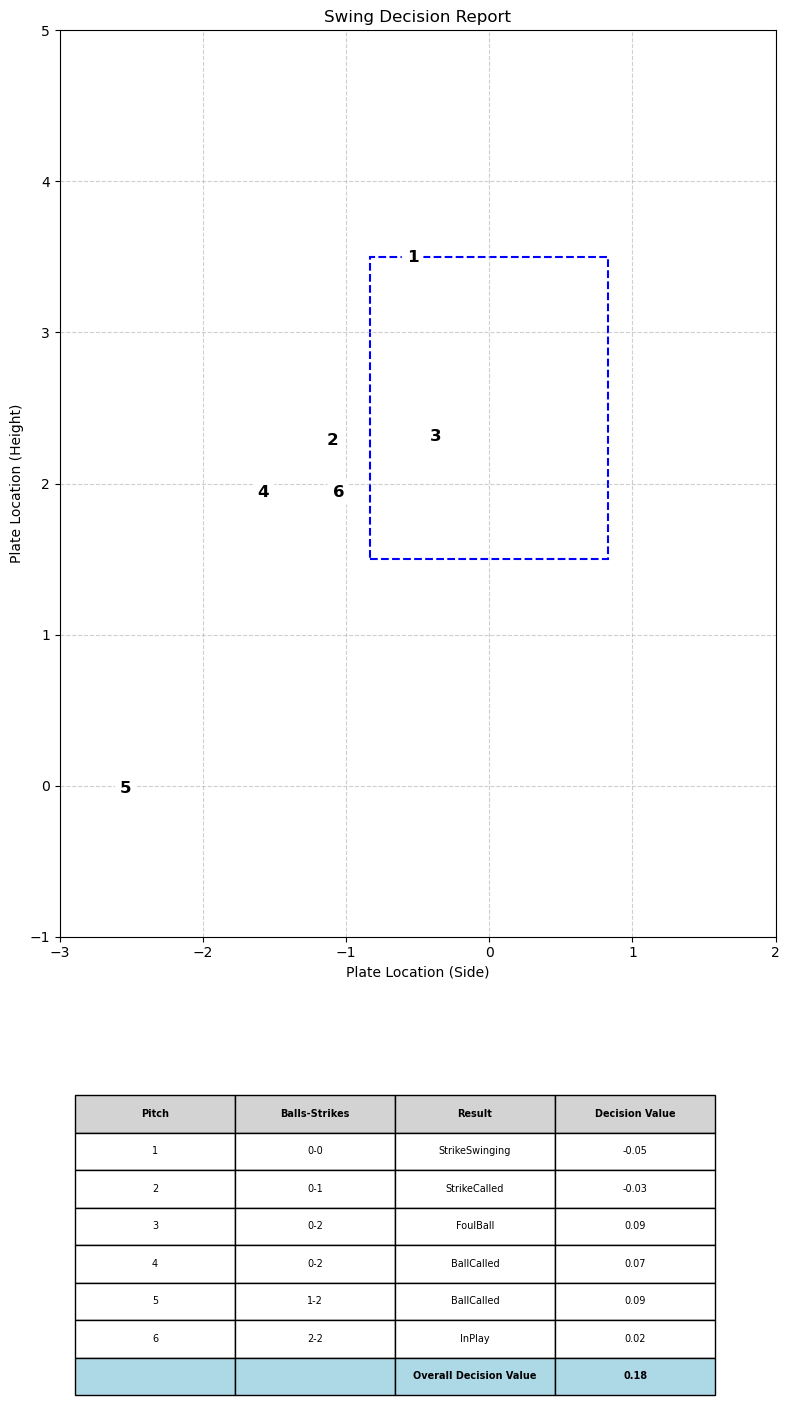

In [47]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report = sample_report.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range


# Plot each pitch and annotate with pitch number
for idx, row in sample_report.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background



# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],  # Use the value from the PitchCall column
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_12086/64165520.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


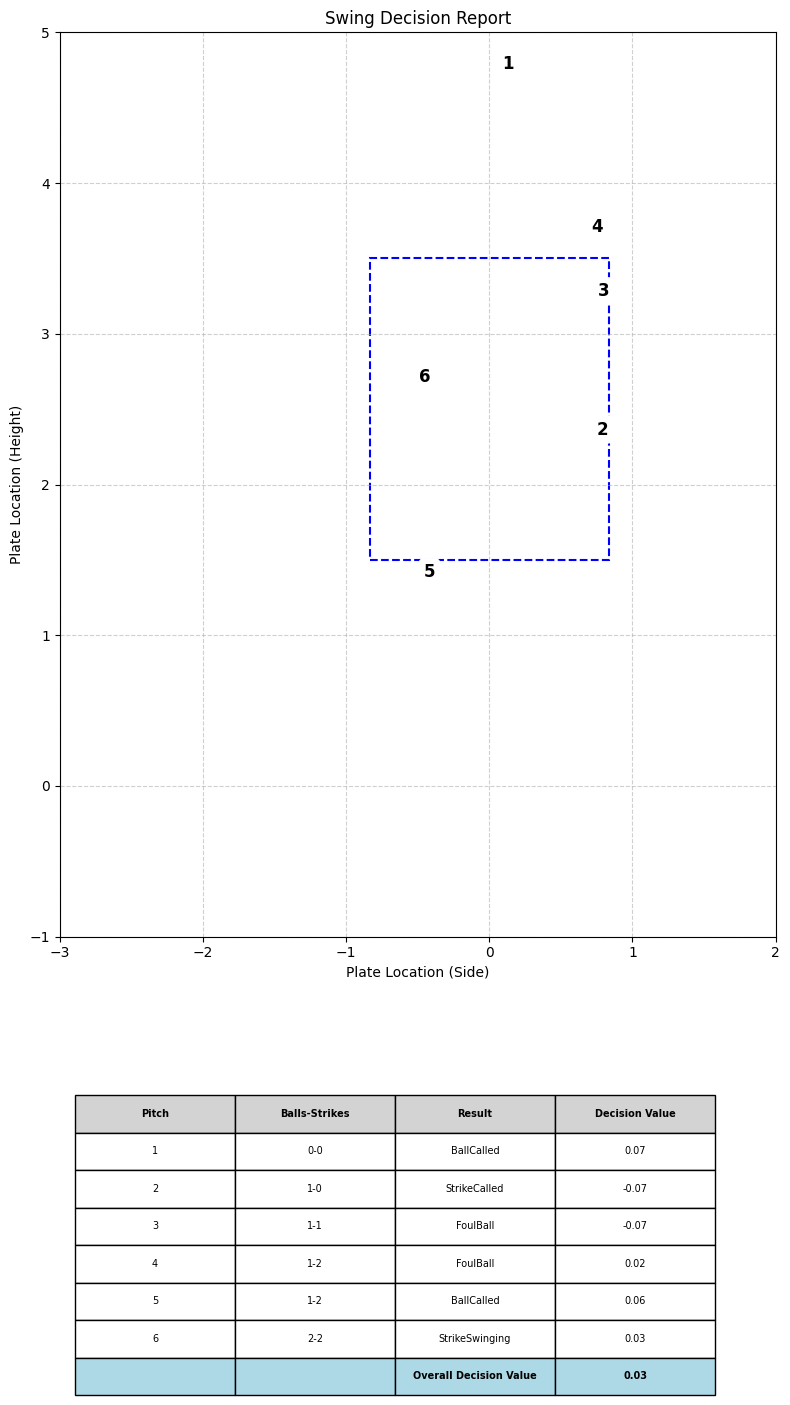

In [240]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report2 = sample_report2.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range

# Plot each pitch and annotate with pitch number
for idx, row in sample_report2.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background

# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report2.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report2['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()

/var/folders/vj/mr9gtxyd13s7vdvt74wwnw3h0000gn/T/ipykernel_12086/579363597.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


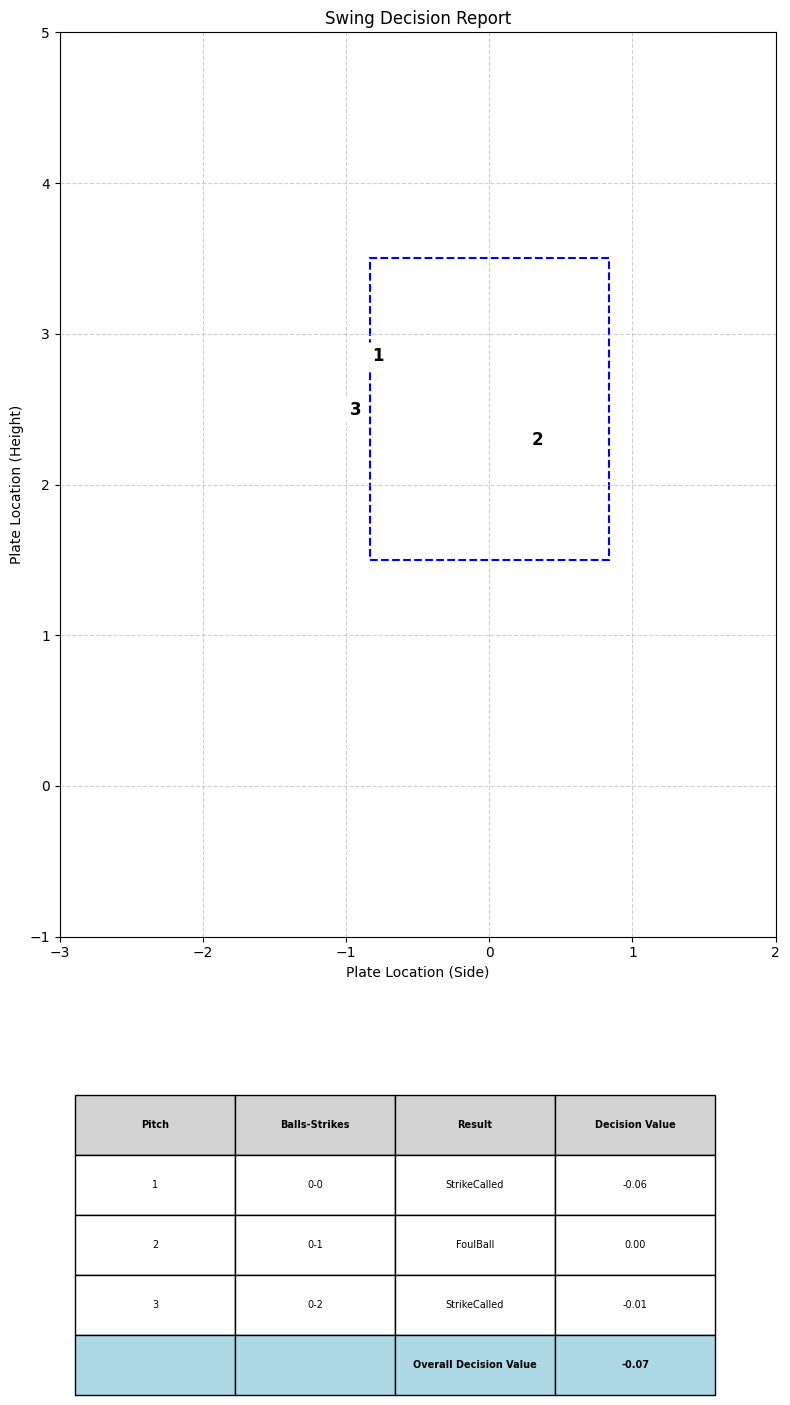

In [247]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Reset index to ensure proper sequential numbering from 1 to 6
sample_report3 = sample_report3.reset_index(drop=True)

# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(8, 10))

# Define strike zone boundaries
strike_zone_x_min = -0.833
strike_zone_x_max = 0.833
strike_zone_y_min = 1.5
strike_zone_y_max = 3.5

# Adjust plotting bounds to ensure all pitches are visible
ax.set_xlim(-3, 2)  # Expand based on PlateLocSide range
ax.set_ylim(-1, 5)   # Expand based on PlateLocHeight range


# Plot each pitch and annotate with pitch number
for idx, row in sample_report3.iterrows():
    color = 'green' if row['Swing/Take'] == 'Swing' else 'red'  # Color for swing/take
    pitch_number = idx + 1  # Number pitches 1 through 6
    
    # Plot the dot
    ax.scatter(row['PlateLocSide'], row['PlateLocHeight'], color=color, s=100, edgecolor='black')
    
    # Annotate with a bold number and a white background
    ax.text(row['PlateLocSide'], row['PlateLocHeight'], 
            str(pitch_number), 
            fontsize=12,  # Larger font size
            fontweight='bold',  # Bold font
            color='black',  # Black text color
            ha='center', va='center',  # Center alignment
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Add a white background



# Add the strike zone rectangle
strike_zone = plt.Rectangle((strike_zone_x_min, strike_zone_y_min), 
                             strike_zone_x_max - strike_zone_x_min, 
                             strike_zone_y_max - strike_zone_y_min,
                             edgecolor='blue', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(strike_zone)

# Customize the plot
ax.set_title(f"Swing Decision Report")
ax.set_xlabel('Plate Location (Side)')
ax.set_ylabel('Plate Location (Height)')
ax.grid(True, linestyle='--', alpha=0.6)

# Add the table below the plot
table_data = [['Pitch', 'Balls-Strikes', 'Result', 'Decision Value']]
for idx, row in sample_report3.iterrows():
    pitch_number = idx + 1
    table_data.append([
        pitch_number, 
        f"{row['Balls']}-{row['Strikes']}",
        row['PitchCall'],  # Use the value from the PitchCall column
        f"{row['decision_value']:.2f}"
    ])

# Calculate the overall decision value
overall_decision_value = sample_report3['decision_value'].sum()
table_data.append(["", "", "Overall Decision Value", f"{overall_decision_value:.2f}"])

# Create the table
table_ax = fig.add_axes([0.1, -0.4, 0.8, 0.3])  # Adjust position and size as needed
table_ax.axis('off')
pitch_table = Table(table_ax, bbox=[0, 0, 1, 1])

# Add cells to the table
n_rows = len(table_data)
n_cols = len(table_data[0])
cell_width = 1.0 / n_cols
cell_height = 1.0 / n_rows

for i, row in enumerate(table_data):
    for j, cell_value in enumerate(row):
        cell = pitch_table.add_cell(i, j, width=cell_width, height=cell_height, text=cell_value, loc='center', facecolor='white')
        if i == 0:  # Header row
            cell.set_facecolor('lightgrey')
            cell.set_text_props(fontsize=10, fontweight='bold')  # Correct method for font properties
        if i == len(table_data) - 1:  # Bottom row for overall decision value
            cell.set_facecolor('lightblue')
            cell.set_text_props(fontsize=10, fontweight='bold')
        cell.set_edgecolor('black')

# Add the table to the axes
table_ax.add_table(pitch_table)

# Show the plot
plt.tight_layout()
plt.show()

In [205]:
sample_report3[['Balls', 'Strikes', 'Swing/Take', 'PlayResult', 'PitchCall', 'swing_value', 'take_value', 'PlateLocSide', 'PlateLocHeight']]

,Balls,Strikes,Swing/Take,PlayResult,PitchCall,swing_value,take_value,PlateLocSide,PlateLocHeight
0,0,0,Take,Undefined,StrikeCalled,0.254945,-1.019257,0.43634,1.78187
1,0,1,Swing,Undefined,FoulBall,0.505912,-1.119193,-0.71789,2.84230
2,0,2,Take,Undefined,BallCalled,1.269508,0.516704,-0.82237,4.61781
3,1,2,Swing,Undefined,FoulBall,2.214628,-0.301022,-0.49565,2.26463
4,1,2,Take,Undefined,BallCalled,0.788392,1.168406,0.26332,4.53118
5,2,2,Swing,Undefined,StrikeSwinging,0.663671,0.279937,0.47026,3.35700


13